# EAFExp - Análise: distribuição angular de múons  

Vamos utilizar os dados coletados por nosso setup experimental para analisar o fluxo e a distribuição angular de múons que chegam à superfície da Terra no Rio de Janeiro. O *setup* experimental que utilizamos para coletar dados é formado por um par de *Resistive Plate Chambers* (RPCs) separadas verticalmente por uma distância fixa de 180 cm. Cada RPC possui 64 *pads* independentes de leitura, com dimensões 19cm x 15cm.

<img src="esquema.png" width="400" height="200"/>


Os dados coletados por nosso *setup* experimental consistem em arquivos de texto contendo duas "palavras" (*string*s) de 64-*bits*: um conjunto de 128 dígitos. Os 64 primeiros dígitos correspondem às *pads* da RPC de cima, enquanto os 64 últimos digitos correspondem às *pads* da RPC de baixo. Cada linha do arquivo corresponde a um evento de detecção em coincidência, isto é, corresponde à leitura de um sinal elétrico em pelo menos uma pad de cada RPC simultaneamente. Para as RPCs onde houve detecção de algum sinal elétrico, o dígito registrado será 1; para as demais, será 0. Por exemplo, para a linha: 00100000... 000000...001, podemos dizer que o evento ocorreu nas pads 3 (da RPC superior) e 64 (da RPC inferior).

Nossa primeira tarefa é, então, ler os arquivos de texto que contém essas informações e identificar, para cada evento, o número da *pad* sensibilizada em cada uma das RPCs. Podemos fazer isso de diferentes maneiras, que serão indicadas a seguir. Posteriormente, precisaremos aprender a extrair informações sobre a **trajetória** dos múons a partir do número das *pads* sensibilizadas e das dimensões do nosso detector.

## Inspecionando um arquivo de dados

Antes de escrevermos um código para extrair o número das *pads* onde houve detecção para cada evento coletado, vamos primeiro inspecionar um arquivo de dados: `sem_chumbo_test.txt`. Este arquivo contém apenas poucos eventos, e vamos utilizá-lo apenas numa primeira etapa para entender os algoritmos a seguir. Abra o arquivo `sem_chumbo_test.txt` e responda, fazendo apenas uma inspeção visual:

1. Quantos eventos estão registrados nesse arquivo? <details><summary>*R*:</summary> Cada linha representa um evento, logo há 3 eventos nesse arquivo.</details>

2. Quais as *pads* em que houve detecção em cada RPC, para cada evento? <details><summary>*R*:</summary>RPC de cima: pads 1, 6, 13; RPC de baixo: 64, 61, 3. </details>


## Leitura dos arquivos de dados - método 1

A ideia é simples, embora não muito eficiente: 
1. varrer os arquivos de dados, lendo uma linha por vez;
2. salvar cada coluna de cada linha em uma string;
3. percorrer as strings, verificando se cada elemento é igual a 1: se sim, guarda a posição do elemento
Assim, poderemos identificar as pads em cada RPC onde houve um hit.
Veja a função abaixo, getNpads_1(), que implementa este tipo de algoritmo para retornar listas contendo os números das pads onde houve detecção.

*Obs*: você entende por quê fazemos `append(i+1)` e não `append(i)` para inserir a posição da RPC na lista? <details><summary>*R*:</summary> Porque as listas são indexadas a partir do 0, portanto a varredura vai de 0 a 63 correspondendo aos elementos entre 1 e 64 das strings.</details> 

In [1]:
def getNpads_1(nome_arquivo='sem_chumbo_test.txt'):
    arquivo = open(nome_arquivo, 'r')          #le o arquivo txt
    nPads_RPC1, nPads_RPC2 = [], []
    for linha in arquivo:                      #1. varre o arquivo de dados, lendo uma linha por vez
        rpcs = linha.split()                   #2. separa cada linha em um array de duas strings: rpc => [rpc1, rpc2] 
        n_pads = len(rpcs[0])                  # n_pads => numero de pads (iguais nas 2 rpcs) igual ao tamanho de cada string
        rpc1 = rpcs[0]
        rpc2 = rpcs[1]
        for i in range(n_pads):                #3. percorre as strings verificando se cada elemento é igual a 1
            if rpc1[i] == "1":                 # se o elemento é igual a 1, guarda a posição do elemento na lista correspondente
                nPads_RPC1.append(i+1)
            if rpc2[i] == "1":
                nPads_RPC2.append(i+1)

    return nPads_RPC1, nPads_RPC2

getNpads_1()

([1, 6, 13], [64, 61, 3])

In [3]:
def getNpads_1(nome_arquivo='sem_chumbov1.txt'):
    arquivo = open(nome_arquivo, 'r')          #le o arquivo txt
    nPads_RPC1, nPads_RPC2 = [], []
    for linha in arquivo:                      #1. varre o arquivo de dados, lendo uma linha por vez
        rpcs = linha.split()                   #2. separa cada linha em um array de duas strings: rpc => [rpc1, rpc2] 
        n_pads = len(rpcs[0])                  # n_pads => numero de pads (iguais nas 2 rpcs) igual ao tamanho de cada string
        rpc1 = rpcs[0]
        rpc2 = rpcs[1]
        for i in range(n_pads):                #3. percorre as strings verificando se cada elemento é igual a 1
            if rpc1[i] == "1":                 # se o elemento é igual a 1, guarda a posição do elemento na lista correspondente
                nPads_RPC1.append(i+1)
            if rpc2[i] == "1":
                nPads_RPC2.append(i+1)

    return nPads_RPC1, nPads_RPC2

getNpads_1()

## Leitura do arquivo de dados - método 2

Uma forma mais eficiente de identificar as *pads* onde houve coincidência é utilizando... **logaritmos**!
Basta observar que, para um evento onde a detecção ocorreu na *pad* 1 para a primeira RPC, por exemplo, a primeira coluna é composta pelo dígito 1 seguido de 63 dígitos 0. Como um número, isso representa 10^(63). Note que o logaritmo na base 10 de uma potência de 10 nos dirá exatamente quantos dígitos 0 temos **depois** do dígito 1. Logo, podemos calcular então a *pad* correspondente fazendo simplesmente 64 - log(10^63) = 1. 

Desse modo, podemos identificar as *pads* sem precisar fazer muitas comparações. Simples, não?! Veja a implementação em código na função getNpads_2() a seguir:

In [ ]:
from math import log10

def getNpads_2(nome_arquivo='sem_chumbo_test.txt'):
    arquivo = open(nome_arquivo, 'r')          #le o arquivo txt
    nPads_RPC1, nPads_RPC2 = [], []
    for linha in arquivo:                      #1. varre o arquivo de dados, lendo uma linha por vez
        rpcs = linha.split()                   #2. separa cada linha em um array de duas strings: rpc => [rpc1, rpc2] 
        n_pads = len(rpcs[0])                  # n_pads => numero de pads (iguais nas 2 rpcs) igual ao tamanho de cada string
        rpc1 = int(rpcs[0])                    #3. converte as strings em numeros inteiros
        rpc2 = int(rpcs[1])
        nPads_RPC1.append(int(n_pads - log10(rpc1))) 
        nPads_RPC2.append(int(n_pads - log10(rpc2)))

    return nPads_RPC1, nPads_RPC2

getNpads_2()

## Determinação das trajetórias

Agora que sabemos identificar o número das *pads* onde houve detecção, precisamos entender como fazer a correspondência entre os números das *pads* e as coordenadas espaciais, isto é, as **posições** por onde passaram os múons. Evidentemente, a posição em termos absolutos depende de adotarmos um referencial. No entanto, veremos que a posição absoluta não nos interessa; estaremos mais interessados na **posição relativa** entre as *pads* sensibilizadas das RPC de cima e de baixo para cada evento. De todo modo, isto requer um conhecimento prévio de outras informações, como a numeração e disposição das *pads* ao longo das RPCs e seus tamanhos.

As RPCs estão numeradas igualmente de acordo com a seguinte mapa 2D em forma de matriz (vista da RPC por cima):

```python 
disposicao das pads =[
    [8, 16, 24, 32, 40, 48, 56, 64], #todos os numeros desta linha sao multiplos de 8
    [7, 15, 23, 31, 39, 47, 55, 63], 
    [6, 14, 22, 30, 38, 46, 54, 62],
    [5, 13, 21, 29, 37, 45, 53, 61], 
    [4, 12, 20, 28, 36, 44, 52, 60],
    [3, 11, 19, 27, 35, 43, 51, 59],
    [2, 10, 18, 26, 34, 42, 50, 58],
    [1,  9, 17, 25, 33, 41, 49, 57]]
    numero da pad = (i-1)*8 + j
```

Por conveniência, admitiremos que as RPCs estão dispostas horizontalmente no plano xy e espaçadas verticalmente no eixo z, com eixo x indo da esquerda pra direita, eixo y de baixo pra cima, e z saindo da tela. Observe que, como as *pads* possuem tamanho fixo, a distância (em um dos eixos x ou y) entre *pads* corresponde sempre a um **múltiplo do tamanho da *pad*** nessa direção; ou seja, se as *pads* possuem 15 cm de tamanho ao longo do eixo x, a distância no eixo x entre os centros das pads 1 e 9 é de 15 cm; entre as pads 1 e 17 é 30 cm, e assim por diante. De maneira análoga, se o tamanho das *pads* no eixo y é de 19 cm, a distância no eixo y entre as *pads* 1 e 2 é de 19 cm; entre as pads 1 e 3 é de 38 cm, e assim por diante. 

Observe que a distância no eixo x depende então das **colunas** correspondentes às *pads* e a distância no eixo y das **linhas**, de acordo com a disposição 2D apresentada. Podemos então generalizar essa relação através das expressões a seguir, onde convencionamos `Lx=15cm` o tamanho das *pads* no eixo x, `Ly=19cm` o tamanho das *pads* no eixo y, e consideramos a distância entre duas *pads* denotada por $\delta X$ e $\delta Y$, nos eixos x e y respectivamente: 

$$
\delta X = (coluna_{pad_1} - coluna_{pad_2})\times L_x \\
\delta Y = (linha_{pad_1} - linha_{pad_2})\times L_y
$$

Precisamos, então, converter o número da *pad* na linha e coluna correspondente do mapa 2D de numeração. Isso pode ser feito de diferentes maneiras, observando que cada coluna abriga oito linhas. Veja, por exemplo, a função getLineAndCol() abaixo.


In [ ]:
def getLineAndCol(Npad):
    line, col = Npad, 1
    while(line > 8):
        line = line - 8
    while(Npad > 8):
        Npad = Npad - 8
        col = col + 1

    return line, col   

Teste rodar a função `getLineAndCol()` com diferentes valores de Npad e compare com o que você esperava ao olhar o mapa de disposição 2D da numeração das *pads*. Os resultados fazem sentido?

In [ ]:
getLineAndCol(64)

De posse do número da linha e da coluna correspondentes, podemos então calcular as distâncias nos eixos x e y, `deltaX` e `deltaY`, conforme definimos anteriormente. Com os valores de `deltaX`, de `deltaY` e da distância entre as RPCs, que denotaremos por `H`, poderemos então calcular outras duas informações: os ângulos **azimutal** e **zenital**. Para isto, precisamos considerar a geometria da trajetória, conforme ilustrado na figura a seguir:

![coordenadas](coordenadas.png)

Podemos definir, portanto, as funções `getDeltaX()`, `getDeltaY()`, `getZen()` e `getAzi()` conforme feito a seguir: 

In [ ]:
from math import sqrt, atan, asin, pi

Lx = 15 #cm
Ly = 19 #cm
H = 80 #cm

def getDeltaX(col_pad1, col_pad2):
    return (col_pad1 - col_pad2)*Lx

def getDeltaY(lin_pad1, lin_pad2):
    return (lin_pad1 - lin_pad2)*Ly

def getZen(deltaX, deltaY):
    diag = sqrt(deltaX*deltaX + deltaY*deltaY)
    return (180 * atan(diag / H)/pi)

def getAzi(deltaX, deltaY):
    diag = sqrt(deltaX*deltaX + deltaY*deltaY)
    azi = asin(deltaY/diag)
    if (deltaX) <= 0.:
        azi = pi - azi
    if azi < 0 and (deltaX) > 0.:
        azi = 2*pi + azi
    return 180*azi/pi

Podemos então chamar estas funções em conjunto para calcular os ângulos zenital e azimutal, dando como input apenas os índices das *pads* onde houve detecção, como feito na função `calcAngles()` a seguir:

In [ ]:
def calcAngles(Npad1, Npad2):
    lin_pad1, col_pad1 = getLineAndCol(Npad1)
    lin_pad2, col_pad2 = getLineAndCol(Npad2)

    deltaX = getDeltaX(col_pad1, col_pad2)
    deltaY = getDeltaY(lin_pad1, lin_pad2)

    zen = getZen(deltaX, deltaY)
    azi = getAzi(deltaX, deltaY)
    
    return azi, zen

Experimente brincar com os índices das *pads* e rodar a função:

In [ ]:
calcAngles(2, 14)

## O output: visualizando nossos resultados

Finalmente, podemos juntar tudo que fizemos até aqui para analisar um arquivo de dados real. 
Precisamos apenas aprender a organizar nossos resultados de modo que possamos visualizá-los, analisá-los e apresentá-los a nossos pares na comunidade acadêmica. Para isso, vamos utilizar as bibliotecas `matplotlib` e `numpy`.

Observe o código abaixo:

In [47]:
from math import sqrt, atan, asin, log10, pi
from matplotlib import pyplot as plt
import numpy as np 

Lx = 15 #cm
Ly = 19 #cm
H = 80 #cm

def getNpads(nome_arquivo='sem_chumbo_test.txt'):
    arquivo = open(nome_arquivo, 'r')          #le o arquivo txt
    nPads_RPC1, nPads_RPC2 = [], []
    for linha in arquivo:                      #1. varre o arquivo de dados, lendo uma linha por vez
        rpcs = linha.split()                   #2. separa cada linha em um array de duas strings: rpc => [rpc1, rpc2] 
        n_pads = len(rpcs[0])                  # n_pads => numero de pads (iguais nas 2 rpcs) igual ao tamanho de cada string
        rpc1 = int(rpcs[0])                    #3. converte as strings em numeros inteiros
        rpc2 = int(rpcs[1])
        nPads_RPC1.append(int(n_pads - log10(rpc1))) 
        nPads_RPC2.append(int(n_pads - log10(rpc2)))

    return nPads_RPC1, nPads_RPC2

def getLineAndCol(Npad):
    line, col = Npad, 1
    while(line > 8):
        line = line - 8
    while(Npad > 8):
        Npad = Npad - 8
        col = col + 1

    return line, col   

def getDeltaX(col_pad1, col_pad2):
    return (col_pad1 - col_pad2)*Lx

def getDeltaY(lin_pad1, lin_pad2):
    return (lin_pad1 - lin_pad2)*Ly

def getZen(deltaX, deltaY):
    diag = sqrt(deltaX*deltaX + deltaY*deltaY)
    return (180 * atan(diag / H)/pi)

def getAzi(deltaX, deltaY):
    diag = sqrt(deltaX*deltaX + deltaY*deltaY)
    if(diag > 0):
        azi = asin(deltaY/diag)
        if (deltaX) <= 0.:
            azi = pi - azi
        if azi < 0 and (deltaX) > 0.:
            azi = 2*pi + azi
        return 180*azi/pi
    else:
        return 0

def calcAngles(Npad1, Npad2):
    lin_pad1, col_pad1 = getLineAndCol(Npad1)
    lin_pad2, col_pad2 = getLineAndCol(Npad2)

    deltaX = getDeltaX(col_pad1, col_pad2)
    deltaY = getDeltaY(lin_pad1, lin_pad2)

    zen = getZen(deltaX, deltaY)
    azi = getAzi(deltaX, deltaY)
    
    return azi, zen



Vamos usar as funções definidas para ler e analisar o arquivo de dados `sem_chumbov1.txt`:

In [48]:
# from ROOT import TH2D, TCanvas

nPads_RPC1, nPads_RPC2 = getNpads('sem_chumbov1.txt')
azimutal, zenital = [], []
line_RPC1, col_RPC1 = [], []
line_RPC2, col_RPC2 = [], []

# h2_top = TH2D("h2_top", "", 8, 0.5, 8.5, 8, 0.5, 8.5)

for i in range(len(nPads_RPC1)):
    azi, zen = calcAngles(nPads_RPC1[i], nPads_RPC2[i])
    azimutal.append(azi)
    zenital.append(zen)
    
    line1, col1 = getLineAndCol(nPads_RPC1[i])
    line2, col2 = getLineAndCol(nPads_RPC2[i])
    line_RPC1.append(line1)
    line_RPC2.append(line2)
    col_RPC1.append(col1)
    col_RPC2.append(col2)

    # h2_top.Fill(col1, line1)
    
    
Npads_1, Npads_2 = np.array(nPads_RPC1), np.array(nPads_RPC2)
Azimute, Zenite = np.array(azimutal), np.array(zenital)

In [5]:
print(len(n))

875994


Agora, podemos produzir *plots* das distribuições de contagens em função do número da *pad* em cada uma das RPCs de maneira bastante simples:

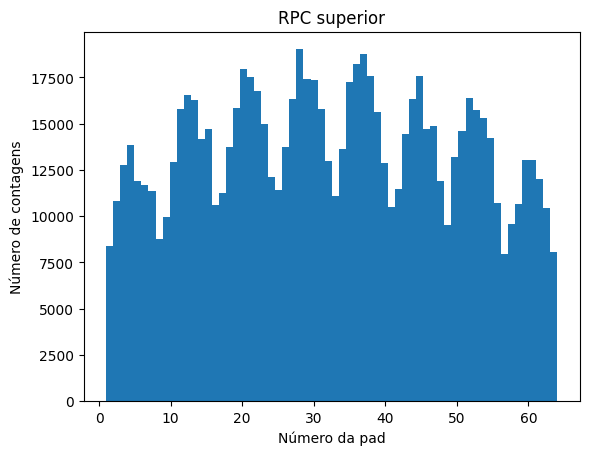

In [50]:
plt.hist(Npads_2, bins=64)
plt.ylabel("Número de contagens")
plt.xlabel("Número da pad")
plt.title("RPC superior")
plt.show()

*Obs*: Por quê existe um *bin* vazio no histograma do número de contagens na RPC superior? A que *pad* corresponde? <details><summary>*R*:</summary> Porque há uma *pad* defeituosa na RPC superior, cuja leitura é 0. É a pad 38.</details>

In [ ]:
plt.hist(Npads_2, bins=64)
plt.ylabel("Número de contagens")
plt.xlabel("Número da pad")
plt.title("RPC inferior")
plt.show()

Podemos ver ainda a distribuição de eventos em 2D ao longo da RPC, como quem vê a RPC de cima. Nesse caso teremos um mapa de cores, indicado no eixo z, com o número de contagens em cada pad. Para os *plots* abaixo, uma cor mais clara indica menos eventos, enquanto uma cor mais vermelha e escura indica mais eventos, de 0 a 20000. 

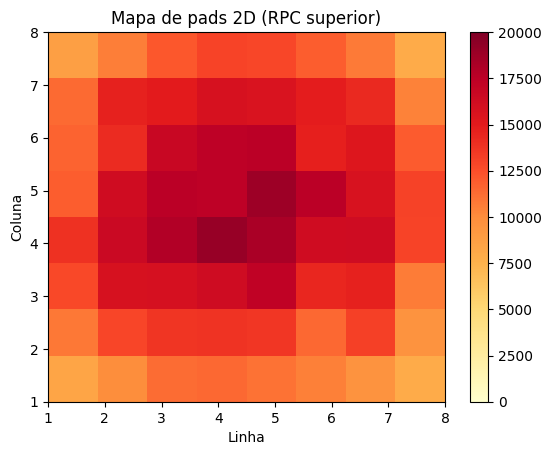

In [52]:
plt.hist2d(col_RPC2, line_RPC2, bins=[8,8], cmap="YlOrRd", vmin=0, vmax=20000)
plt.colorbar()
plt.ylabel("Coluna")
plt.xlabel("Linha")
plt.title("Mapa de pads 2D (RPC superior)")
plt.show()

In [ ]:
plt.hist2d(col_RPC2, line_RPC2, bins=[8,8], cmap="YlOrRd", vmin=0, vmax=20000)
plt.colorbar()
plt.ylabel("Coluna")
plt.xlabel("Linha")
plt.title("Mapa de pads 2D (RPC inferior)")
plt.show()

Vamos agora ver as distribuições em função dos ângulos azimutal e zenital. O que você espera da aparência dessas distribuições?

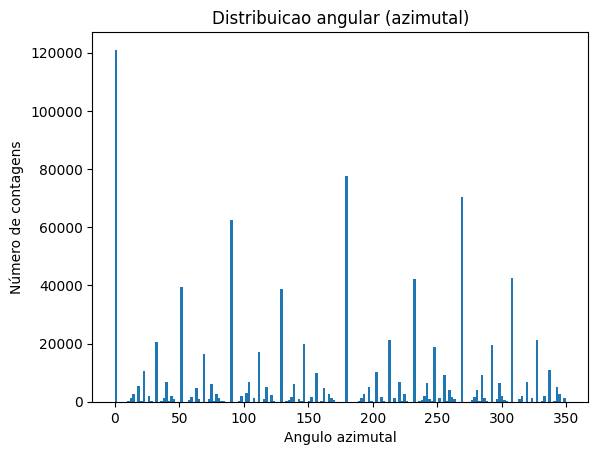

In [53]:
plt.hist(Azimute, bins=180, histtype='stepfilled')
plt.ylabel("Número de contagens")
plt.xlabel("Angulo azimutal")
plt.title("Distribuicao angular (azimutal)")
plt.show()

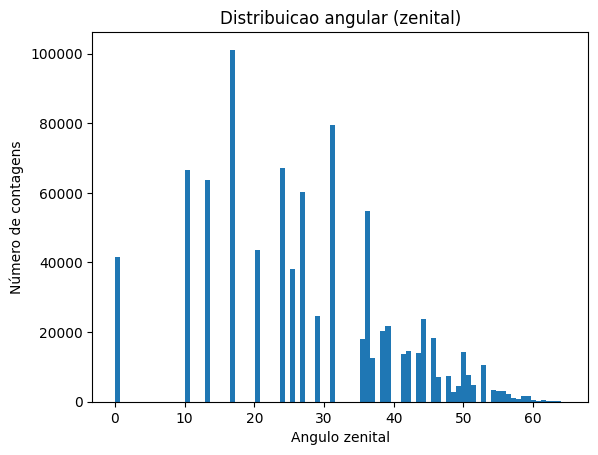

In [54]:
plt.hist(Zenite, bins=90)
plt.ylabel("Número de contagens")
plt.xlabel("Angulo zenital")
plt.title("Distribuicao angular (zenital)")
plt.show()

## Eficiência geométrica
Vamos agora usar simulação para determinar a eficiência geométrica das diferentes pads.

In [4]:
from math import sqrt, atan, asin, log10, pi
from matplotlib import pyplot as plt
import numpy as np
from numpy import pi, tan, cos, sin, random

Lx = 15 #cm 50./8
Ly = 19 #cm 50./8
H = 80 #cm

# Lx = 50./8
# Ly = 50./8
# H = 30 


def getLineAndCol(Npad):
    line, col = Npad, 1
    while(line > 8):
        line = line - 8
    while(Npad > 8):
        Npad = Npad - 8
        col = col + 1

    return line, col   

def sortcos2():
    one_theta=0.0
    while True:
        sample_theta_ = random.rand() * ( pi / 2 )
        sample_y_ = random.rand()
        cos2theta_ = cos( sample_theta_ ) ** 2
        # cos2theta_ = cos( sample_theta_ )
        # cos2theta_ = cos( sample_theta_ ) ** 2.5
        if sample_y_ < cos2theta_:
            one_theta = sample_theta_
            break    
    return one_theta

def sortInRange(min, max):
    return np.random.rand()*(max - min)

def padCenter(Npad):
    line, col = getLineAndCol(Npad)
    return (col-0.5)*Lx, (line-0.5)*Ly

def deg2rad(angle):
    return angle*pi/180.

def calcPos(Npad1, zen, azi):
    radius  = abs(H*np.tan(deg2rad(zen)))
    x2    = padCenter(Npad1)[0] + radius*np.cos(deg2rad(azi))
    y2    = padCenter(Npad1)[1] + radius*np.sin(deg2rad(azi))
    return x2, y2

# def calcPos(x1, y1, zen, azi):
#     radius  = abs(H*np.tan(deg2rad(zen)))
#     x2    = x1 + radius*np.cos(deg2rad(azi))
#     y2    = y1 + radius*np.sin(deg2rad(azi))
#     return x2, y2
    
def IsInsideRPC(x, y):
    return ((x > 0. and x <= 8*Lx) and (y > 0. and y <= 8*Ly))

def simulation(Nevts, Npad1_list, zen_list, azi_list, Npads=64, uniform=False):
    
    eff_list = []
    for pad in range(1,Npads+1):
        Nhits = 0
        for ievt in range(0,Nevts):
            if(uniform):
                zen = sortInRange(0, 90)
            else:
                zen = sortcos2()*180./pi
            azi = sortInRange(0, 360)
            x, y = calcPos(pad, zen, azi)
            # x, y = calcPos(x1, y1, zen, azi)
                
            if(IsInsideRPC(x,y)):
                Npad1_list.append(pad)
                zen_list.append(zen)
                azi_list.append(azi)
                Nhits = Nhits + 1
        eff_list.append(Nhits/Nevts)
        
    return eff_list

In [3]:
from math import sqrt, atan, asin, log10, pi
from matplotlib import pyplot as plt
from numpy import pi, tan, cos, sin, random

L = 50. # cm
H = 30. 

def sortInRange(min, max):
    return random.rand()*(max - min)

def sortcos2():
    one_theta=0.0
    while True:
        sample_theta_ = random.rand() * ( pi / 2 )
        sample_y_ = random.rand()
        cos2theta_ = cos( sample_theta_ ) ** 2
        # cos2theta_ = cos( sample_theta_ )
        # cos2theta_ = cos( sample_theta_ ) ** 2.5
        if sample_y_ < cos2theta_:
            one_theta = sample_theta_
            break    
    return one_theta

def propagate(zen,azi,x_i,y_i,z_i,z_f):
    zen_tan=tan(zen)
    slopex=cos(azi)*zen_tan 
    slopey=sin(azi)*zen_tan
    x_f=x_i+(z_f-z_i)*slopex 
    y_f=y_i+(z_f-z_i)*slopey 
    return x_f,y_f

def simulation_cos2(Nevts):   
    Nhits = 0
    for ievt in range(0,Nevts):
        zen = sortcos2()
        # zen = sortInRange(0,pi/2.)
        azi = sortInRange(0,2*pi)
        x_top=sortInRange(0,L)
        y_top=sortInRange(0,L)    
        x_bottom,y_bottom=propagate(zen,azi,x_top,y_top,0,H)
        if(0<=x_bottom<=L and 0<=y_bottom<=L):
            Nhits+=1
    return Nhits/Nevts

print(simulation_cos2(1000000))

0.623424


Vamos usar a função `simulation()` com 100000 eventos para obter uma lista com as eficiências para cada uma das pads:

In [8]:
Nevts = 1000000
Npad1_list, zen_list, azi_list = [], [], []
eff_list = simulation(Nevts, Npad1_list, zen_list, azi_list, 64, True)
print('Npad1_list:', len(Npad1_list))
print('Ntracks:', 64*Nevts)
print('Nhits/Ntracks*2pi/3: ', len(Npad1_list)/(64*Nevts)*2*pi/3.)
print('eff_list: ', eff_list)
Npads_1 = np.array(Npad1_list)
Azimute, Zenite = np.array(azi_list), np.array(zen_list)

Npad1_list: 24637599
Ntracks: 64000000
Nhits/Ntracks*2pi/3:  0.8062635418801171
eff_list:  [0.265769, 0.318398, 0.34296, 0.354596, 0.353891, 0.344144, 0.317755, 0.267129, 0.313565, 0.378536, 0.409418, 0.421926, 0.422369, 0.408693, 0.377505, 0.313651, 0.338524, 0.40832, 0.444066, 0.458679, 0.458167, 0.444466, 0.409343, 0.338438, 0.349227, 0.422807, 0.458724, 0.475697, 0.474725, 0.459028, 0.423612, 0.349263, 0.349212, 0.421343, 0.4584, 0.473884, 0.474436, 0.459053, 0.422865, 0.349129, 0.339051, 0.408136, 0.444203, 0.457833, 0.458283, 0.443833, 0.408003, 0.338843, 0.314514, 0.37773, 0.409044, 0.422026, 0.422217, 0.408817, 0.376965, 0.313537, 0.266584, 0.31749, 0.342873, 0.354684, 0.354561, 0.342642, 0.318044, 0.265973]


In [9]:
eff_list_cos2 = simulation(Nevts, Npad1_list, zen_list, azi_list, 64, False)
print('eff_list_cos2: ', eff_list_cos2)

eff_list_cos2:  [0.41844, 0.509721, 0.550567, 0.567692, 0.567369, 0.550475, 0.509418, 0.418527, 0.506993, 0.623659, 0.673921, 0.694216, 0.693328, 0.674318, 0.622815, 0.507422, 0.549276, 0.678485, 0.735948, 0.758219, 0.758553, 0.736159, 0.678655, 0.550289, 0.568673, 0.701581, 0.76246, 0.786403, 0.787167, 0.76234, 0.702504, 0.56822, 0.567356, 0.702293, 0.763191, 0.787212, 0.787029, 0.762879, 0.702879, 0.568374, 0.549782, 0.678368, 0.736424, 0.758396, 0.758519, 0.736313, 0.678439, 0.550031, 0.507194, 0.623432, 0.67418, 0.694391, 0.693469, 0.672836, 0.623005, 0.506707, 0.418602, 0.510355, 0.551344, 0.567625, 0.568096, 0.550535, 0.509202, 0.417992]


In [10]:
print('ratio: ', np.array(eff_list_cos2)/np.array(eff_list))

ratio:  [1.57444999 1.60089259 1.60533882 1.60095433 1.60323094 1.59954844
 1.60317855 1.56675988 1.61686732 1.64755532 1.64604634 1.64535013
 1.64152199 1.64993773 1.64981921 1.61779175 1.62256147 1.66165018
 1.65729419 1.6530493  1.65562557 1.65627742 1.6579128  1.62596694
 1.62837639 1.65934102 1.66213235 1.65315947 1.65815367 1.66077015
 1.65836662 1.62691153 1.62467498 1.66679641 1.66490183 1.66119135
 1.65887285 1.66185386 1.66218297 1.62797705 1.62153186 1.66211263
 1.65785463 1.65649047 1.65513231 1.6589866  1.66282846 1.6232621
 1.61262774 1.65046991 1.64818455 1.64537493 1.64244689 1.64581218
 1.65268659 1.61609954 1.57024428 1.60746795 1.6080123  1.60036822
 1.6022518  1.60673531 1.60104262 1.57155802]


Podemos fazer um gráfico da eficiência em função da pad:

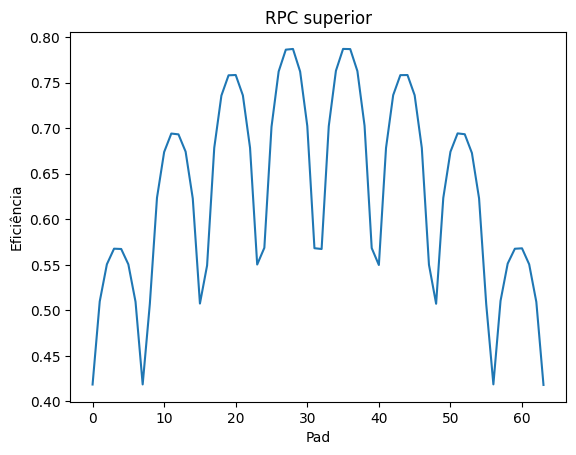

In [12]:
plt.plot(eff_list_cos2)
plt.ylabel("Eficiência")
plt.xlabel("Pad")
plt.title("RPC superior")
plt.show()

Responda: a distribuição da eficiência tem o formato que você esperava? Por quê?

### Fluxo de múons

Agora que determinamos a eficiência e temos o número de eventos observados, ambos em função das pads da RPC, podemos obter o fluxo de múons em cada pad! O fluxo $F_i$, onde $i$ é um indice referente à pad da RPC ($i=1,...,64$), é dado pela expressão:

$$
F_i = \frac{N_{obs}^{i}}{A\times \Delta t\times \varepsilon_{geom.}^{i}\times \varepsilon_{det.}^{i} \times \omega(\theta)}.
$$

Na expressão acima, para cada pad, $A=L_x \times L_y$ é a área, $\Delta t$ o tempo de coleta de dados, $N_{obs}^{i}$ é o número de contagens observada e $\varepsilon_{geom.}^{i}$ a eficiência geométrica, $\varepsilon_{det.}^{i}$ a eficiência de detecção, e $\omega(\theta)$ um fator angular devido à incidência não isotrópica de múons. 

In [1]:
from ROOT import TH1D, TH2D, TColor, gStyle

hFlux_Top = TH1D("hFlux_Top", "Fluxo por pad;Pad; Contagens / m^2", 64, 0.5, 64.5)
hNcor_Top_2D = TH2D("hNcor_Top_2D", "Fluxo por pad; Pad; Pad", 8, 0.5, 8.5, 8, 0.5, 8.5)
hFlux_Top_2D = TH2D("hFlux_Top_2D", "Fluxo por pad; Pad; Pad", 8, 0.5, 8.5, 8, 0.5, 8.5)
overArea = 100*100./(Lx*Ly) #multiplicado por 100*100 para passar de cm^-2 para m^-2
overDeltaT = 1./28482 #tempo de coleta
eff_det = 0.80
# ang_factor = 2*pi/3. #cosTheta
ang_factor = 5./3 #cos2theta
for i in nPads_RPC1:
    hFlux_Top.Fill(i, 1./eff_list[i-1]*overArea*overDeltaT)
    line, col = getLineAndCol(i)
    hNcor_Top_2D.Fill(col, line, 1./eff_list[i-1])
    hFlux_Top_2D.Fill(col, line, 1./(eff_list[i-1]*eff_det)*overArea*overDeltaT)

ModuleNotFoundError: No module named 'ROOT'

Com isso, podemos agora "plotar" os resultados:

In [ ]:
c1 = TCanvas("c1", "", 600, 600)
hFlux_Top.SetStats(0)
hFlux_Top.Draw("EP")
c1.Draw()

In [ ]:
gStyle.SetPadRightMargin(0.20)
gStyle.SetPalette(75)
TColor.InvertPalette()
c2 = TCanvas("c2", "", 600, 600)
hNcor_Top_2D.SetStats(0)
hNcor_Top_2D.Draw("COLZ")
c2.Draw()

In [ ]:
c3 = TCanvas("c3", "", 600, 600)
hFlux_Top_2D.SetStats(0)
hFlux_Top_2D.Draw("COLZ")
c3.Draw()

Observe como o padrão em 2D é bem mais uniforme após a correção pela eficiência!